In [24]:
from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, transpile, assemble
from qiskit_aer import AerSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import circuit_drawer
from qiskit.tools.visualization import plot_histogram
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error, errors)
from qiskit.providers.fake_provider import FakeVigo
from qiskit.extensions import XGate


In [3]:
p_error = 0.5
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
print(bit_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.5, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.5, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


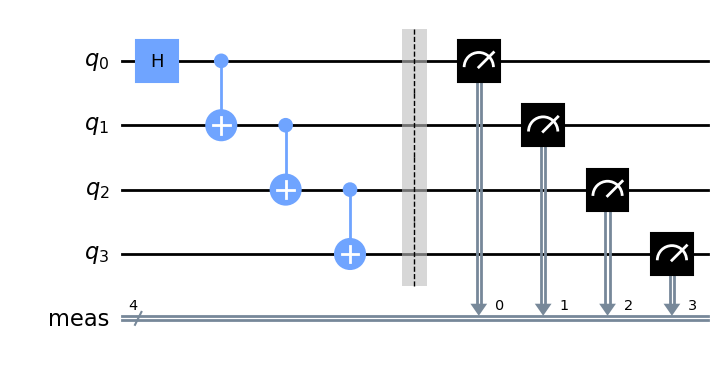

In [8]:
n_qubits = 4 
circ = QuantumCircuit(n_qubits)
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
circ.draw(output='mpl', style="clifford")


Simulación ideal

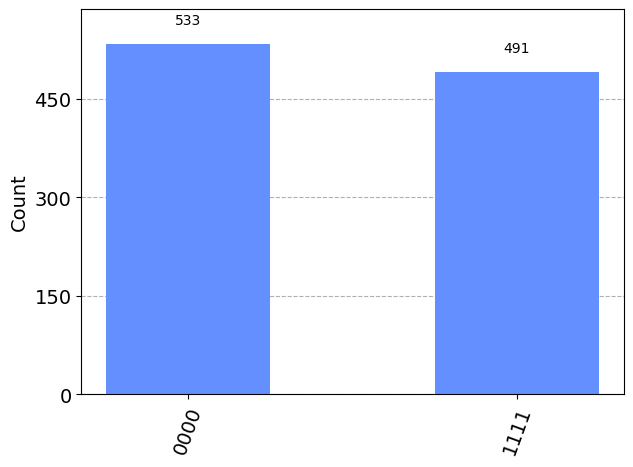

In [18]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

In [42]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.95

# QuantumError objects
#error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
#error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
#error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
#noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
#noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
#noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u1', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3']


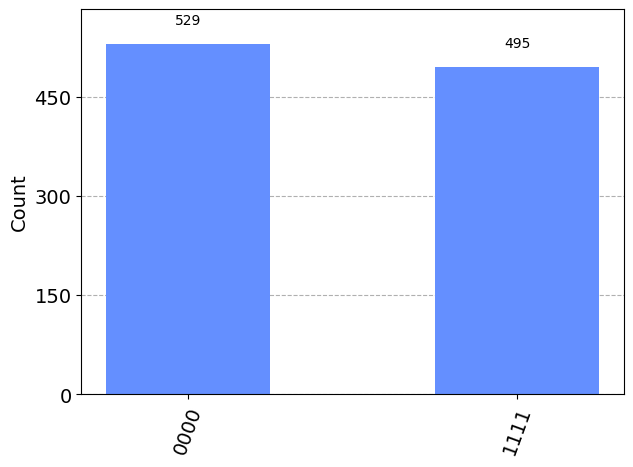

In [17]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

In [47]:
x_gate = XGate()  # regular X gate
x1_gate = XGate(label="x1")  # first labelled X gate 
x2_gate = XGate(label="x2")  # second labelled X gate

x1_error = pauli_error([('X',0.9), ('I', 1 - 0.9)])
x2_error = errors.depolarizing_error(0.01, 1)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(x1_error, x1_gate.label)
noise_model.add_all_qubit_quantum_error(x2_error, x2_gate.label)
noise_model.add_basis_gates(['x'])
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['x1', 'x2']
  All-qubits errors: ['x1', 'x2']


     ┌────┐┌─┐
q_0: ┤ x1 ├┤M├
     └────┘└╥┘
q_1: ───────╫─
            ║ 
q_2: ───────╫─
            ║ 
c: 1/═══════╩═
            0 


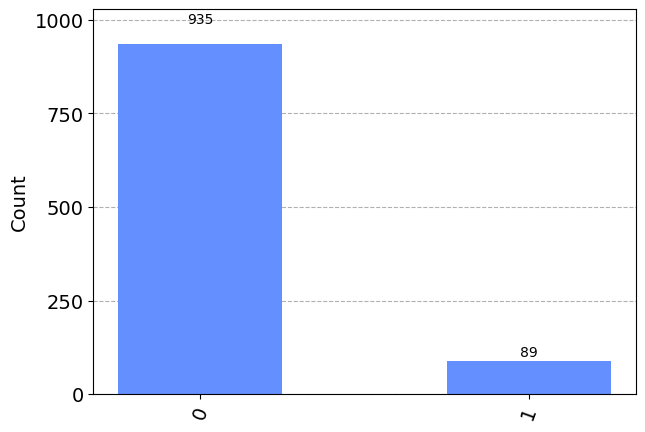

In [48]:
qc = QuantumCircuit(3, 1)



qc.append(x1_gate, [0])  # regular noise-free x gate
#qc.append(x1_gate, [1])  # noisy x1 gate
#qc.append(x2_gate, [2])  # noisy x2 gate
qc.measure([0], [0])
print(qc)

result = execute(qc, Aer.get_backend('qasm_simulator'),
                 noise_model=noise_model).result()
result.get_counts(0)

plot_histogram(result.get_counts(0))

